# Аналіз часових рядів: індекс волатильності VIX

У цьому ноутбуці досліджується часовий ряд індексу волатильності VIX: виконано візуалізацію, перевірку на стаціонарність та декомпозицію.


## Мета роботи
1. Обрати та завантажити репрезентативний набір даних, що представляє собою часовий ряд.

2. Візуалізувати часовий ряд.

3. Виконати попередню обробку даних: перевірку на пропуски, фільтрацію та зменшення кількості атрибутів (для багатовимірних рядів).

Для виконнаня роботи було обрано датасет "[US Stock Market 2020-2024](https://www.kaggle.com/datasets/dhavalpatel555/us-stock-market-2020-to-2024)" з Kaggle, який містить щоденні дані про акції та індекси фондового ринку США за період з 2020 по 2024 рік.

Для аналізу буде використовуватися закриття торгів (Close) як основний часовий ряд.



## 1. Завантаження та візуалізація даних


Побудуємо графік динаміки цін акцій за період 2020–2024 роки.

Спершу імпортуємо необхідні бібліотеки для виконання завдань.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### 1.1 Завантаження CSV і перегляд структури

In [ ]:
url = 'https://raw.githubusercontent.com/datasets/finance-vix/master/data/vix-daily.csv'
df = pd.read_csv(url)

df.head()

,DATE,OPEN,HIGH,LOW,CLOSE
0,01/02/1990,17.24,17.24,17.24,17.24
1,01/03/1990,18.19,18.19,18.19,18.19
2,01/04/1990,19.22,19.22,19.22,19.22
3,01/05/1990,20.11,20.11,20.11,20.11
4,01/08/1990,20.26,20.26,20.26,20.26


І нарешті переходимо до візуалізації.

### 1.2 Побудова повного часового ряду
Динаміка індексу волатильності VIX (1990–сьогодні)

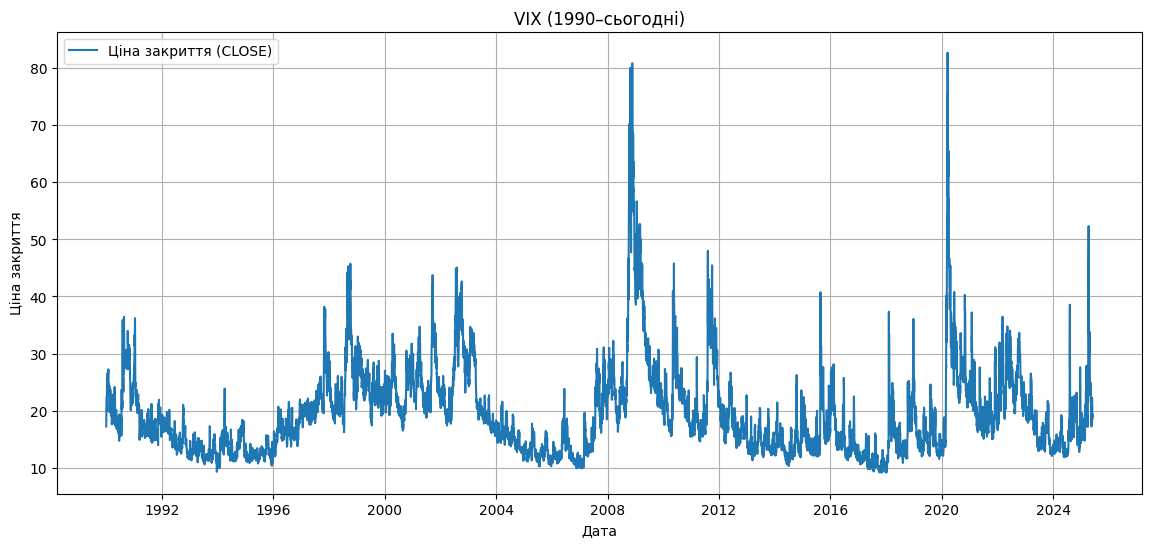

In [ ]:
df['DATE'] = pd.to_datetime(df['DATE'])
df.set_index('DATE', inplace=True)

plt.figure(figsize=(14, 6))
plt.plot(df.index, df['CLOSE'], color='tab:blue', label='Ціна закриття (CLOSE)')
plt.title('VIX (1990–сьогодні)')
plt.xlabel('Дата')
plt.ylabel('Ціна закриття')
plt.grid(True)
plt.legend()
plt.show()

Графік показує динаміку індексу волатильності VIX упродовж 30 років.
Можна виявити періоди різкої волатильності, які можуть співпадати з фінансовими кризами або глобальними подіями, наприклад, 2008 або 2020 років.

Ці дані добре підходять для побудови моделей ARIMA/SARIMA після попередньої обробки.

## 2. Попередня обробка

2.1 Перевіримо наявність пропущених значень:

In [ ]:
missing_values = df.isnull().sum()
print("Пропущені значення у кожному стовпці:")
print(missing_values)

Пропущені значення у кожному стовпці:
OPEN     0
HIGH     0
LOW      0
CLOSE    0
dtype: int64


Ми перевірили наявність пропущених значень у кожному стовпці. У цьому датасеті відсутні пропуски, відповідно очищення відсутніх записів не потрібне, тож можемо переходити до наступного пункту завдання:

2.2 фільтрація аномальних значень - залишаємо лише значення `CLOSE` більше за 0 (оскільки індекс не може бути від'ємним або нульовим).

In [ ]:
print("Мінімальне значення CLOSE:", df['CLOSE'].min())

df_filtered = df[df['CLOSE'] > 0]

Мінімальне значення CLOSE: 9.14


З метою видалення потенційних аномальних значень було виконано фільтрацію задля усунення потенційних технічних помилок або шуму.

2.3 Далі переходимо до зменшення кількості атрибутів, залишивши для аналізу тільки стовпчик `CLOSE`. Це дозволить зосередитись на одному показнику (ціна закриття), що спрощує подальше моделювання та прогнозування.

In [ ]:
df_final = df_filtered[['CLOSE']]
df_final.head()

,CLOSE
DATE,
1990-01-02,17.24
1990-01-03,18.19
1990-01-04,19.22
1990-01-05,20.11
1990-01-08,20.26


## 3. Тест на стаціонарність: ADF

Як нам відомо, стаціонарність - це властивість часового ряду, при якій його середнє, дисперсія та автокореляція не змінюються з часом, що є обов’язковою умовою для побудови моделей AR, MA, ARIMA, SARIMA.


Графік, який було створено вище у пункті візуалізації, характеризується періодами високої волатильності (кризи 2008 та 2020 років), коливанням навколо змінного середнього значення, та відсутністю явного лінійного тренду (тобто середнє коливається, але не зростає/спадає постійно).

Це вже *може* свідчити про стаціонарність, але потрібне формальне підтвердження.

Тому проведемо тест Дікі-Фуллера (ADF). Цей тест перевіряє нульову гіпотезу: що ряд **не є стаціонарним** (має одиничний корінь). Якщо **p-value < 0.05**, ми **відхиляємо нульову гіпотезу** і визнаємо ряд стаціонарним:

In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_final['CLOSE'])

print('ADF статистика:', result[0])
print('p-value:', result[1])
print('Критичні значення:')
for key, value in result[4].items():
    print(f'  {key}: {value}')

ADF статистика: -7.20349273225139
p-value: 2.3324208257799795e-10
Критичні значення:
  1%: -3.43108265917886
  5%: -2.8618637874933555
  10%: -2.5669423470685637


Як ми бачимо, значення ADF статистики `-7.20` **менше** за всі критичні значення, а p-value **значно менше 0.05**.
Це чітко свідчить про те, що часовий ряд є стаціонарним, тож у  диференціюванні **немає потреби**.

## 4. Тест на стаціонарність: KPSS

На відміну від ADF, тут нульова гіпотеза — стаціонарність

Якщо p-value < 0.05, то ряд не стаціонарний

In [ ]:
!pip install statsmodels


In [ ]:
from statsmodels.tsa.stattools import kpss

kpss_stat, p_value, lags, crit = kpss(df['CLOSE'], regression='c', nlags="auto")

print("KPSS статистика:", kpss_stat)
print("p-value:", p_value)
print("Критичні значення:")
for key, value in crit.items():
    print(f"  {key}: {value}")

KPSS статистика: 0.34762498528848834
p-value: 0.09973060978944467
Критичні значення:
  10%: 0.347
  5%: 0.463
  2.5%: 0.574
  1%: 0.739


## 5. Адитивна декомпозиція часового ряду


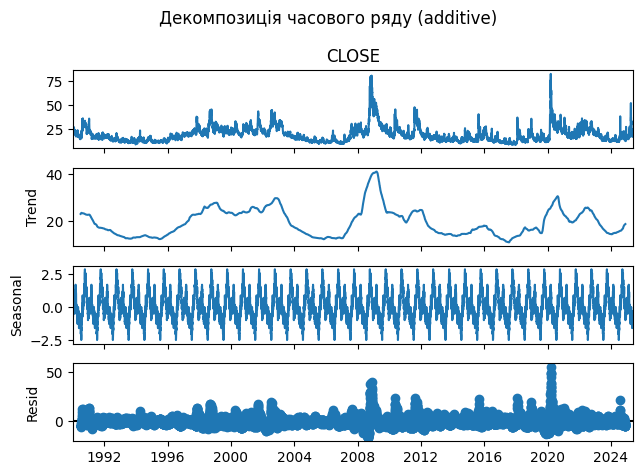

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df['CLOSE'], model='additive', period=252)  #рік у біржових днях
decomposition.plot()
plt.suptitle("Декомпозиція часового ряду (additive)")
plt.tight_layout()
plt.show()

# Прогнозування часового ряду

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.stats.diagnostic import het_arch
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore")

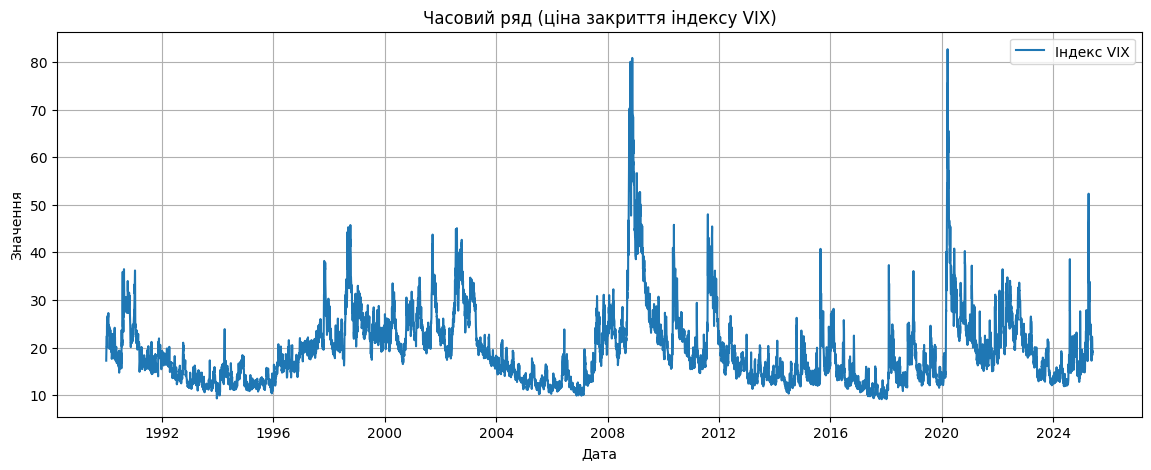

In [ ]:
url = "https://raw.githubusercontent.com/datasets/finance-vix/master/data/vix-daily.csv"
df = pd.read_csv(url)

df['DATE'] = pd.to_datetime(df['DATE'])
df.set_index('DATE', inplace=True)

series = df['CLOSE']
series = series.asfreq('B') # Бізнес-дні
series = series.interpolate(method='time')

plt.figure(figsize=(14,5))
plt.plot(series, label="Індекс VIX")
plt.title("Часовий ряд (ціна закриття індексу VIX)")
plt.xlabel("Дата")
plt.ylabel("Значення")
plt.legend()
plt.grid(True)
plt.show()

## Перевірка гетероскедастичності (ARCH тест)

In [ ]:
!pip install arch

ARCH LM Test — p-value: 0.0000
Є ознаки гетероскедастичності - будуємо GARCH модель
                       Zero Mean - GARCH Model Results                        
Dep. Variable:                  CLOSE   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -57465.6
Distribution:                  Normal   AIC:                           114937.
Method:            Maximum Likelihood   BIC:                           114959.
                                        No. Observations:                 9238
Date:                Mon, Jun 02 2025   Df Residuals:                     9238
Time:                        21:53:02   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
---------------------------------------------------

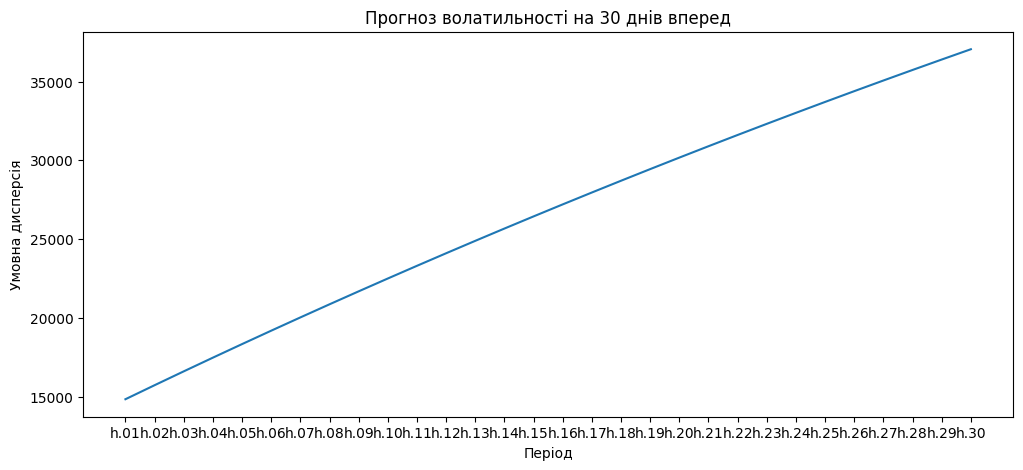

In [ ]:
from statsmodels.stats.diagnostic import het_arch
from arch import arch_model

test_result = het_arch(series.diff().dropna())
print(f"ARCH LM Test — p-value: {test_result[1]:.4f}")

if test_result[1] < 0.05:
    print("Є ознаки гетероскедастичності - будуємо GARCH модель")

    garch_model = arch_model(series.diff().dropna()*100, mean='Zero', vol='GARCH', p=1, q=1)
    garch_result = garch_model.fit(disp='off')
    print(garch_result.summary())

    forecast_horizon = 30
    forecasts = garch_result.forecast(horizon=forecast_horizon)
    forecast_var = forecasts.variance.iloc[-1,:]

    plt.figure(figsize=(12,5))
    plt.plot(forecast_var)
    plt.title(f'Прогноз волатильності на {forecast_horizon} днів вперед')
    plt.ylabel('Умовна дисперсія')
    plt.xlabel('Період')
    plt.show()
else:
    print("Гетероскедастичність не виявлена - можна застосувати класичні моделі.")

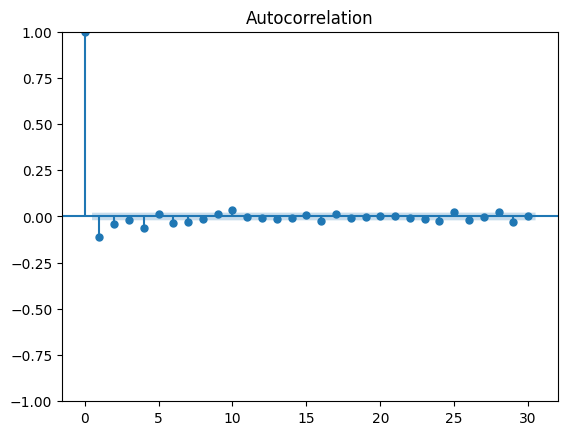

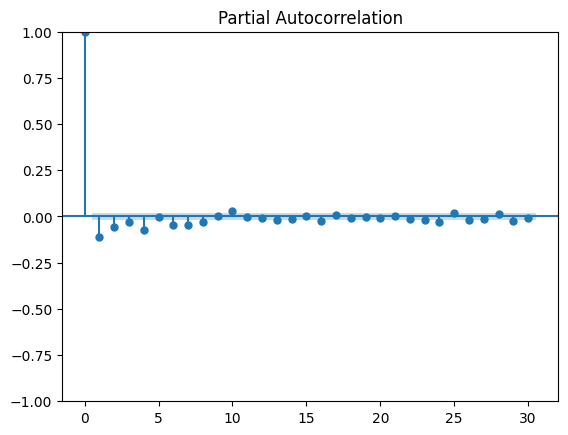

                               SARIMAX Results                                
Dep. Variable:                  CLOSE   No. Observations:                 7391
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -13355.262
Date:                Mon, 02 Jun 2025   AIC                          26716.524
Time:                        21:58:45   BIC                          26737.247
Sample:                    01-02-1990   HQIC                         26723.645
                         - 05-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7105      0.012     58.342      0.000       0.687       0.734
ma.L1         -0.8261      0.010    -86.269      0.000      -0.845      -0.807
sigma2         2.1739      0.010    207.779      0.0

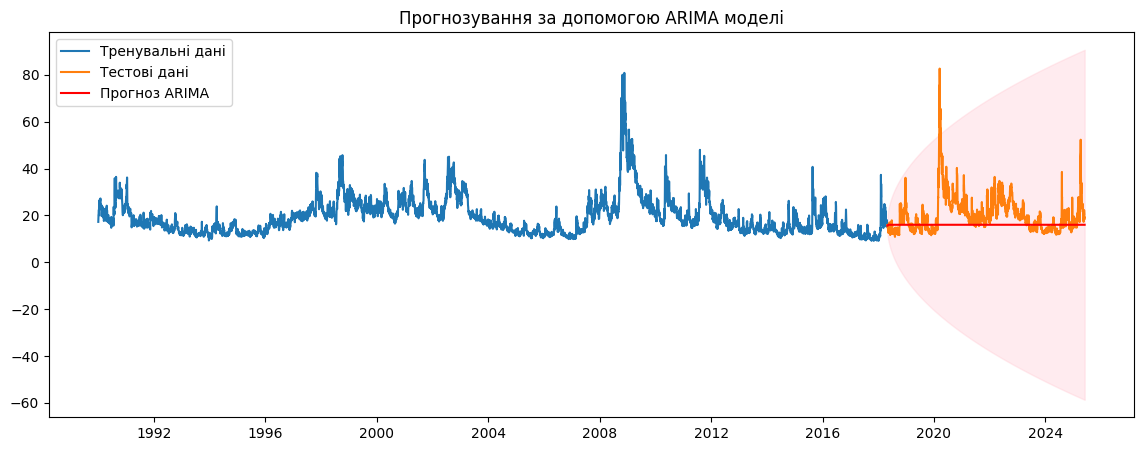

In [ ]:
# Побудова ARIMA моделі (як альтернативи)
train_size = int(len(series)*0.8)
train, test = series[:train_size], series[train_size:]

# Визначення параметрів ARIMA
# Import the plotting functions for ACF and PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(series.diff().dropna(), lags=30)
plt.show()
plot_pacf(series.diff().dropna(), lags=30)
plt.show()

# ARIMA(1,1,1) модель
arima_model = ARIMA(train, order=(1,1,1))
arima_result = arima_model.fit()
print(arima_result.summary())

# Прогнозування
forecast = arima_result.get_forecast(steps=len(test))
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

# Оцінка якості
mae = mean_absolute_error(test, forecast_mean)
rmse = np.sqrt(mean_squared_error(test, forecast_mean))
print(f"\nMAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

# Візуалізація прогнозу
plt.figure(figsize=(14,5))
plt.plot(train.index, train, label='Тренувальні дані')
plt.plot(test.index, test, label='Тестові дані')
plt.plot(test.index, forecast_mean, label='Прогноз ARIMA', color='red')
plt.fill_between(test.index, conf_int.iloc[:,0], conf_int.iloc[:,1], color='pink', alpha=0.3)
plt.title('Прогнозування за допомогою ARIMA моделі')
plt.legend()
plt.show()

## Базовий прогноз для локальної демонстрації

БАЗОВА МОДЕЛЬ ARIMA(1,1,1) - РЕЗУЛЬТАТИ
                               SARIMAX Results                                
Dep. Variable:                  CLOSE   No. Observations:                 7391
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -13355.262
Date:                Mon, 02 Jun 2025   AIC                          26716.524
Time:                        21:59:07   BIC                          26737.247
Sample:                    01-02-1990   HQIC                         26723.645
                         - 05-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7105      0.012     58.342      0.000       0.687       0.734
ma.L1         -0.8261      0.010    -86.269      0.000      -0.845      -0.807
sigma2      

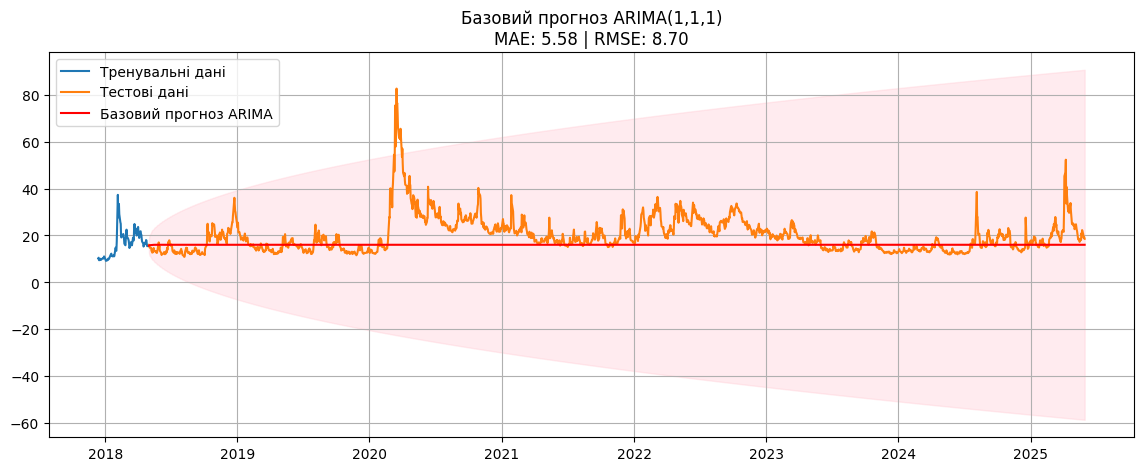

In [ ]:
# 1. Базова ARIMA(1,1,1) модель
base_model = ARIMA(train, order=(1,1,1))
base_results = base_model.fit()

# Діагностика
print("="*60)
print("БАЗОВА МОДЕЛЬ ARIMA(1,1,1) - РЕЗУЛЬТАТИ")
print("="*60)
print(base_results.summary())

# Прогнозування
base_forecast = base_results.get_forecast(steps=len(test))
base_pred = base_forecast.predicted_mean
base_ci = base_forecast.conf_int()

# Оцінка якості
base_mae = mean_absolute_error(test, base_pred)
base_rmse = np.sqrt(mean_squared_error(test, base_pred))
print(f"\nMAE: {base_mae:.2f}")
print(f"RMSE: {base_rmse:.2f}")

# Візуалізація
plt.figure(figsize=(14,5))
plt.plot(train[-100:], label='Тренувальні дані')
plt.plot(test, label='Тестові дані')
plt.plot(base_pred, label='Базовий прогноз ARIMA', color='red')
plt.fill_between(base_ci.index, base_ci.iloc[:,0], base_ci.iloc[:,1], color='pink', alpha=0.3)
plt.title('Базовий прогноз ARIMA(1,1,1)\nMAE: {:.2f} | RMSE: {:.2f}'.format(base_mae, base_rmse))
plt.legend()
plt.grid()
plt.show()

## Покращення у моделі

ПОКРАЩЕНА МОДЕЛЬ ARIMA(1,1,1)-GARCH(1,1) - РЕЗУЛЬТАТИ
                               SARIMAX Results                                
Dep. Variable:                  CLOSE   No. Observations:                 7391
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -13355.262
Date:                Mon, 02 Jun 2025   AIC                          26716.524
Time:                        21:59:54   BIC                          26737.247
Sample:                    01-02-1990   HQIC                         26723.645
                         - 05-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7105      0.012     58.342      0.000       0.687       0.734
ma.L1         -0.8261      0.010    -86.269      0.000      -0.845      -0.80

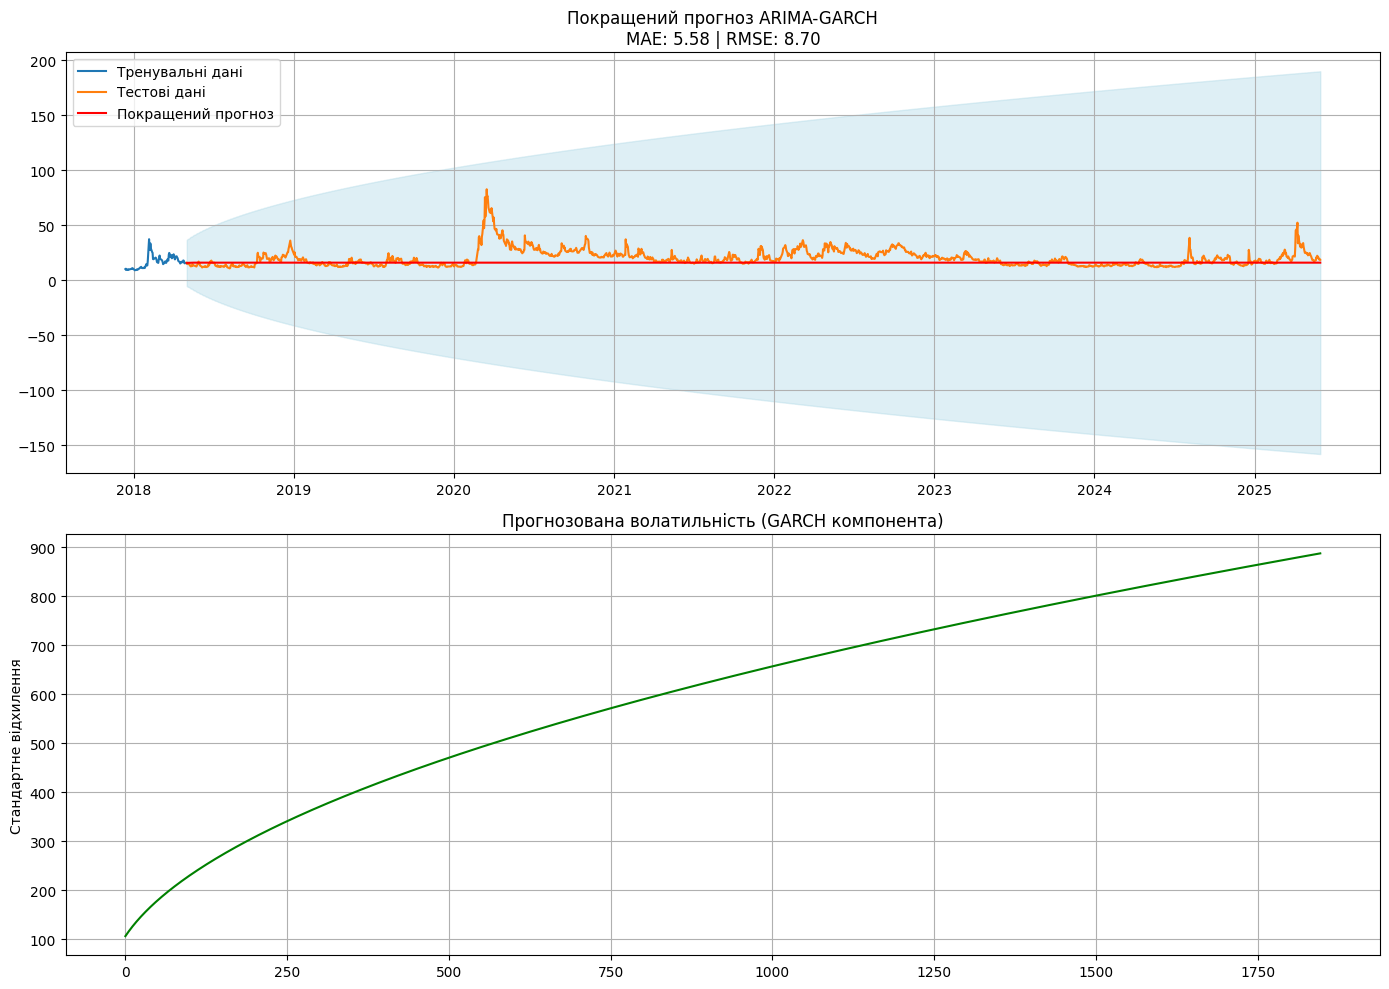

In [ ]:
# 2. Покращена комбінована ARIMA-GARCH модель
from arch import arch_model

# 2.1 Покращена ARIMA з t-розподілом
enhanced_model = ARIMA(train, order=(1,1,1))
enhanced_results = enhanced_model.fit()

# 2.2 GARCH для залишків
garch_model = arch_model(enhanced_results.resid*100, mean='Zero', vol='GARCH', p=1, q=1, dist='StudentsT')
garch_results = garch_model.fit(disp='off')

# Діагностика
print("="*60)
print("ПОКРАЩЕНА МОДЕЛЬ ARIMA(1,1,1)-GARCH(1,1) - РЕЗУЛЬТАТИ")
print("="*60)
print(enhanced_results.summary())
print("\n" + "="*60)
print("GARCH МОДЕЛЬ ДЛЯ ЗАЛИШКІВ")
print("="*60)
print(garch_results.summary())

# Прогнозування
enhanced_forecast = enhanced_results.get_forecast(steps=len(test))
enhanced_pred = enhanced_forecast.predicted_mean

# Корекція довірчих інтервалів з урахуванням GARCH
garch_forecast = garch_results.forecast(horizon=len(test))
adjusted_std = np.sqrt(garch_forecast.variance.values[-1,:]/100)
enhanced_ci = pd.DataFrame({
    'lower': enhanced_pred - 1.96*adjusted_std,
    'upper': enhanced_pred + 1.96*adjusted_std
}, index=test.index)

# Оцінка якості
enhanced_mae = mean_absolute_error(test, enhanced_pred)
enhanced_rmse = np.sqrt(mean_squared_error(test, enhanced_pred))
print(f"\nMAE: {enhanced_mae:.2f}")
print(f"RMSE: {enhanced_rmse:.2f}")

# Візуалізація
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14,10))

# Прогноз значень
ax1.plot(train[-100:], label='Тренувальні дані')
ax1.plot(test, label='Тестові дані')
ax1.plot(enhanced_pred, label='Покращений прогноз', color='red')
ax1.fill_between(enhanced_ci.index, enhanced_ci['lower'], enhanced_ci['upper'], color='lightblue', alpha=0.4)
ax1.set_title('Покращений прогноз ARIMA-GARCH\nMAE: {:.2f} | RMSE: {:.2f}'.format(enhanced_mae, enhanced_rmse))
ax1.legend()
ax1.grid()

# Прогноз волатильності
ax2.plot(np.sqrt(garch_forecast.variance.values[-1,:]), color='green')
ax2.set_title('Прогнозована волатильність (GARCH компонента)')
ax2.set_ylabel('Стандартне відхилення')
ax2.grid()

plt.tight_layout()
plt.show()

## Графік залишків ARIMA

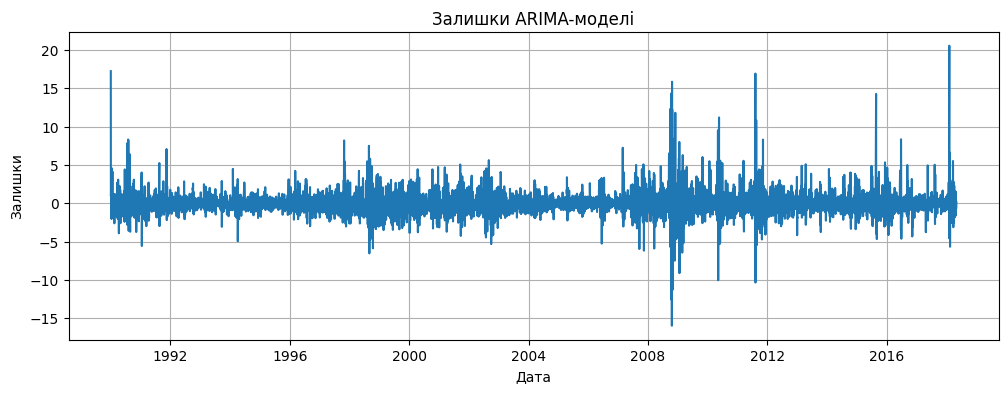

In [ ]:
residuals = enhanced_results.resid
plt.figure(figsize=(12, 4))
plt.plot(residuals)
plt.title("Залишки ARIMA-моделі")
plt.xlabel("Дата")
plt.ylabel("Залишки")
plt.grid()
plt.show()

## Перевірка гіпотези про нормальний розподіл залишків

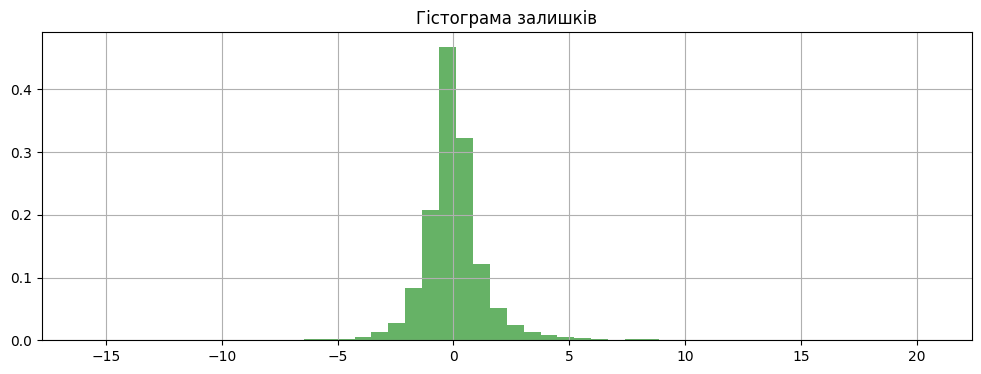

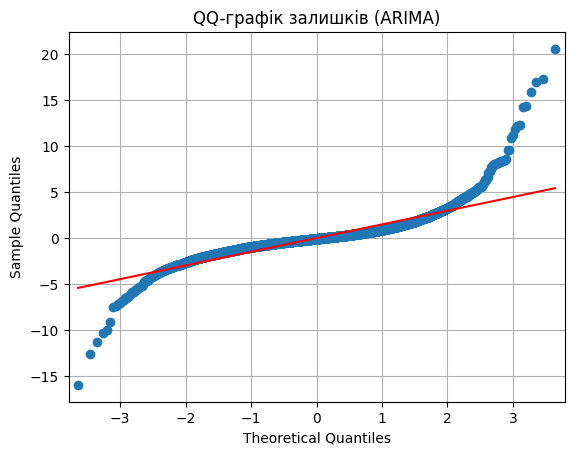

In [ ]:
import scipy.stats as stats
import statsmodels.api as sm

plt.figure(figsize=(12, 4))
plt.hist(residuals, bins=50, density=True, alpha=0.6, color='g')
plt.title("Гістограма залишків")
plt.grid()
plt.show()

sm.qqplot(residuals, line='s')
plt.title("QQ-графік залишків (ARIMA)")
plt.grid()
plt.show()

## STL-декомпозиція часового ряду

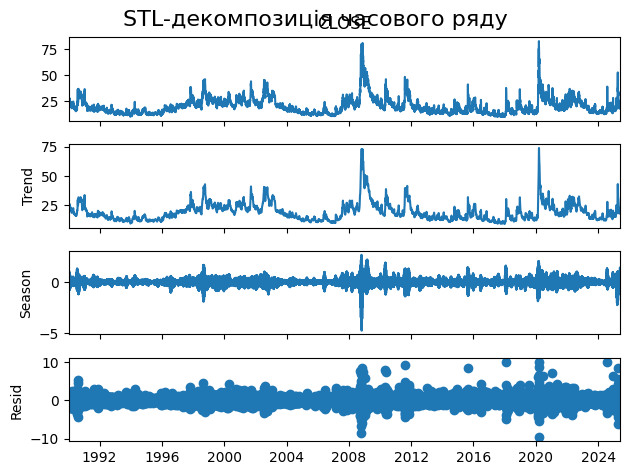

In [ ]:
from statsmodels.tsa.seasonal import STL

stl = STL(series, seasonal=13)
res = stl.fit()
res.plot()
plt.suptitle("STL-декомпозиція часового ряду", fontsize=16)
plt.show()